In [1]:
import numpy as np
import tbparse as tb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scp

sns.set_theme(style="whitegrid")

In [2]:
lw = 3
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Table Results: Dimension Estimates

In [2]:
import torch
from core.model import Model
import skdim
import yaml
import copy

In [12]:
def estimate_dim(path, coords, d, c, N=1000, scale=1e-5):

    log_dir = "lightning_logs/" + path
    config_path = log_dir + "config.yaml"
    ckpt_path = log_dir + "/checkpoints/last.ckpt"
    
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)

    #Load model
    model = Model.load_from_checkpoint(ckpt_path, input_shape=((1,1),(1,1,1,d)), output_shape=(1,1,c), **config["model"])
    state = copy.deepcopy(model.state_dict())

    N = 1000
    samples = np.zeros((N, coords[1].shape[2]*c))

    scale = 1e-5

    for i in range(N):
        #Perturb
        for param in model.parameters():
            if param.requires_grad:
                with torch.no_grad():
                    param.data.add_(scale*torch.randn(param.shape))
    
        #Evaluate
        with torch.no_grad():
            output = model(coords)
    
        #Append sample
        samples[i,:] = output.detach().numpy().flatten()
    
        #Reset state
        model.load_state_dict(state)

    lpca = skdim.id.lPCA().fit_pw(samples[:,:], n_neighbors=100, n_jobs=1)

    return lpca.dimension_

In [10]:
# points = torch.from_numpy(np.load("data/ignition/points.npy").astype(np.float32)).expand(1, 1, -1, -1)
# t = torch.tensor([[0.]])

# coords = (t, points)

# path1 = "ignition/hnet_online_manifold/version_0/"
# path2 = "ignition/hnet_online_fjlt/version_3/"

In [16]:
# print("Post first snapshot: ", estimate_dim(path1, coords, 2, 4))
# print("Post training: ", estimate_dim(path2, coords, 2, 4))

Exact parameter count: 31652
Post first snapshot:  11
Exact parameter count: 31652
Post training:  14


In [17]:
# points = torch.from_numpy(np.load("data/channel_flow/points.npy").astype(np.float32)).expand(1, 1, -1, -1)
# t = torch.tensor([[0.]])

# coords = (t, points)

# path1 = "channel_flow/hnet_online_manifold/version_0/"
# path2 = "channel_flow/hnet_online_fjlt/version_4/"

In [41]:
# print("Post first snapshot: ", estimate_dim(path1, coords, 3, 3))
# print("Post training: ", estimate_dim(path2, coords, 3, 3))

In [ ]:
# points = torch.from_numpy(np.load("data/neuron_transport/points.npy").astype(np.float32)).expand(1, 1, -1, -1)
# t = torch.tensor([[0.]])

# coords = (t, points)

# path1 = "neuron_transport/hnet_online_manifold/version_0/"
# path2 = "neuron_transport/hnet_online_fjlt/version_1/"

In [ ]:
# print("Post first snapshot: ", estimate_dim(path1, coords, 3, 1))
# print("Post training: ", estimate_dim(path2, coords, 3, 1))

# Table Results: Offline V. Online Performance

In [4]:
#Three sig figs
map = lambda x: np.format_float_positional(x, precision=3, unique=False, fractional=False)

#Extract tb logs
dfs = []
for dataset in ["ignition/", "neuron_transport/", "channel_flow/"]:
    log_dir = "lightning_logs/"+dataset
    experiments = ["hnet_offline_full", "hnet_offline_subsample", "hnet_offline_fjlt", "hnet_online_baseline", "hnet_online_subsample", "hnet_online_fjlt"]
    
    df = pd.DataFrame(columns=["metric"]+experiments)
    df["metric"] = ["Mean PSNR", "Std PSNR", "Mean RFE", "Std RFE"]
    
    for i, experiment in enumerate(experiments):
        reader = tb.SummaryReader(log_dir+experiment)
        df_ = reader.scalars
        df_ = df_[df_["tag"].isin(["real_test_avg_PSNR", "real_test_avg_RFError"])]
        
        df.loc[0,experiment] = map(np.mean(df_[df_["tag"] == "real_test_avg_PSNR"]["value"]))
        df.loc[1,experiment] = map(np.std(df_[df_["tag"] == "real_test_avg_PSNR"]["value"]))
        df.loc[2,experiment] = map(np.mean(df_[df_["tag"] == "real_test_avg_RFError"]["value"])*100)
        df.loc[3,experiment] = map(np.std(df_[df_["tag"] == "real_test_avg_RFError"]["value"])*100)

    dfs.append(df)

In [5]:
print("Ignition...")
dfs[0]

Ignition...


,metric,hnet_offline_full,hnet_offline_subsample,hnet_offline_fjlt,hnet_online_baseline,hnet_online_subsample,hnet_online_fjlt
0,Mean PSNR,41.6,37.3,37.1,9.28,40.2,41.7
1,Std PSNR,0.624,1.08,0.919,1.84,1.58,1.18
2,Mean RFE,2.17,4.04,3.87,84.2,3.89,2.64
3,Std RFE,0.193,0.353,0.492,7.22,2.11,0.852


In [6]:
print("Neuron Transport...")
dfs[1]

Neuron Transport...


,metric,hnet_offline_full,hnet_offline_subsample,hnet_offline_fjlt,hnet_online_baseline,hnet_online_subsample,hnet_online_fjlt
0,Mean PSNR,60.4,35.4,48.8,14.5,40.7,58.2
1,Std PSNR,0.362,5.58,6.46,1.60,11.8,0.819
2,Mean RFE,0.566,14.1,2.88,125.,21.0,0.754
3,Std RFE,0.051,20.4,2.28,23.3,36.3,0.0959


In [7]:
print("Channel Flow...")
dfs[2]

Channel Flow...


,metric,hnet_offline_full,hnet_offline_subsample,hnet_offline_fjlt,hnet_online_baseline,hnet_online_subsample,hnet_online_fjlt
0,Mean PSNR,37.4,34.3,34.6,14.3,37.4,37.4
1,Std PSNR,0.45,0.496,0.217,0.444,0.637,0.470
2,Mean RFE,5.37,7.67,7.30,77.2,5.27,5.22
3,Std RFE,0.362,0.464,0.259,1.59,0.46,0.371


# Table Results: Estimated Sketch Size

In [3]:
#Extract tb logs
for (dataset,M) in zip(["ignition/", "neuron_transport/", "channel_flow/"], [11,29,50]):
    log_dir = "lightning_logs/"+dataset
    experiments = ["hnet_offline_full", "hnet_offline_fjlt"]

    df = tb.SummaryReader(log_dir+"hnet_offline_full").scalars
    err_full = np.mean(df[df["tag"] == "real_test_avg_err"]["value"])
        
    df = tb.SummaryReader(log_dir+"hnet_offline_fjlt").scalars
    err_sketch = np.mean(df[df["tag"] == "real_test_avg_err"]["value"])
    
    c = (err_sketch/err_full)**2

    eps = (c-1)/(c+1)

    print(dataset+" Sketch loss: ", err_sketch)
    print(dataset+" Full loss: ", err_full)
    print(dataset+" Observed epsilon: ", eps)
    print(dataset+" Estimated sketch size: ", M/eps**2)
    print()

ignition/ Sketch loss:  0.0485423281788826
ignition/ Full loss:  0.026188473030924798
ignition/ Observed epsilon:  0.5491173953780569
ignition/ Estimated sketch size:  36.480625943469995

neuron_transport/ Sketch loss:  0.03259822763502598
neuron_transport/ Full loss:  0.007569563947618008
neuron_transport/ Observed epsilon:  0.897676379083203
neuron_transport/ Estimated sketch size:  35.988057256102216

channel_flow/ Sketch loss:  0.07167019943396251
channel_flow/ Full loss:  0.05193663015961647
channel_flow/ Observed epsilon:  0.3113600038535945
channel_flow/ Estimated sketch size:  515.7560800539811



In [5]:
36.480625943469995/2500*100

1.4592250377387999

In [6]:
35.988057256102216/116144*100

0.030985722255219568

In [7]:
515.7560800539811/262144*100

0.19674533083113904

# Table Results: Online Regularization Performance

In [3]:
#Three sig figs
map = lambda x: np.format_float_positional(x, precision=3, unique=False, fractional=False)

#Extract tb logs
log_dir = "lightning_logs/ignition/"
experiments = ["hnet_online_hreg", "tinr_online_subsample_0.7%", "tinr_online_fjlt_0.7%", "hnet_online_subsample_0.7%", "hnet_online_fjlt_0.7%"]

df = pd.DataFrame(columns=["metric"]+experiments)
df["metric"] = ["Mean PSNR", "Std PSNR", "Mean RFE", "Std RFE"]

for i, experiment in enumerate(experiments):
    reader = tb.SummaryReader(log_dir+experiment)
    df_ = reader.scalars
    df_ = df_[df_["tag"].isin(["real_test_avg_PSNR", "real_test_avg_RFError"])]
    
    df.loc[0,experiment] = map(np.mean(df_[df_["tag"] == "real_test_avg_PSNR"]["value"]))
    df.loc[1,experiment] = map(np.std(df_[df_["tag"] == "real_test_avg_PSNR"]["value"]))
    df.loc[2,experiment] = map(np.mean(df_[df_["tag"] == "real_test_avg_RFError"]["value"])*100)
    df.loc[3,experiment] = map(np.std(df_[df_["tag"] == "real_test_avg_RFError"]["value"])*100)

In [4]:
df

,metric,hnet_online_hreg,tinr_online_subsample_0.7%,tinr_online_fjlt_0.7%,hnet_online_subsample_0.7%,hnet_online_fjlt_0.7%
0,Mean PSNR,14.2,21.4,27.1,28.2,37.2
1,Std PSNR,2.36,1.44,1.43,9.30,0.67
2,Mean RFE,60.8,49.6,22.6,32.0,4.72
3,Std RFE,31.9,6.71,8.05,27.5,0.469


# Neuron Transport: Performance V. Sketch Size
Fixed compression rate with varying sketch sizes.

In [8]:
#Extract tb logs
sample_factors = {"fjlt": np.linspace(0.001, 0.01, 5)*100, "subsample": np.linspace(0.0055, 0.0145, 5)*100}
df = {}

#fjlt
log_dir = "lightning_logs/neuron_transport/"
experiments = []
experiments = [f"hnet_online_fjlt_%_{i}" for i in range(0,4)]
experiments.append("hnet_online_fjlt")

dfs = []

for i, experiment in enumerate(experiments):
    reader = tb.SummaryReader(log_dir+experiment)
    df_ = reader.scalars
    PSNR = df_[df_["tag"] == "real_test_avg_PSNR"]["value"]
    RFE = df_[df_["tag"] == "real_test_avg_RFError"]["value"]*100

    dfs.append(pd.DataFrame({"Sample Factor": sample_factors["fjlt"][i], "PSNR": PSNR.to_numpy(), "RFE": RFE.to_numpy()}))

df["fjlt"] = pd.concat(dfs, ignore_index=True)

#subsample
log_dir = "lightning_logs/neuron_transport/"
experiments = []
experiments.extend([f"hnet_online_subsample_%_{i}" for i in range(0,4)])
experiments.insert(2, "hnet_online_subsample")

dfs = []

for i, experiment in enumerate(experiments):
    reader = tb.SummaryReader(log_dir+experiment)
    df_ = reader.scalars
    PSNR = df_[df_["tag"] == "real_test_avg_PSNR"]["value"]
    RFE = df_[df_["tag"] == "real_test_avg_RFError"]["value"]*100

    dfs.append(pd.DataFrame({"Sample Factor": sample_factors["subsample"][i], "PSNR": PSNR.to_numpy(), "RFE": RFE.to_numpy()}))

df["subsample"] = pd.concat(dfs, ignore_index=True)

In [9]:
df["fjlt"]

,Sample Factor,PSNR,RFE
0,0.100,52.073406,2.824103
1,0.100,52.260994,2.955901
2,0.100,52.018097,2.994268
3,0.100,52.266544,3.029322
4,0.100,51.839809,2.749467
5,0.325,55.231533,2.012891
6,0.325,55.222870,1.789363
7,0.325,56.763950,1.389776
8,0.325,54.764339,2.135794
9,0.325,54.551746,1.836249


In [10]:
df["subsample"]

,Sample Factor,PSNR,RFE
0,0.550,39.822304,6.202957
1,0.550,15.936255,99.844652
2,0.550,15.913182,100.033772
3,0.550,42.974232,5.024960
4,0.550,39.509281,6.327469
5,0.775,43.043549,4.936758
6,0.775,41.209621,5.361348
7,0.775,40.360958,5.726899
8,0.775,15.920743,99.982649
9,0.775,15.916537,100.042307


In [11]:
#Get offline baseline
df_ = tb.SummaryReader(log_dir+"hnet_offline_full").scalars
df_ = df_[df_["tag"].isin(["real_test_avg_PSNR", "real_test_avg_RFError"])]

mean_PSNR = np.mean(df_[df_["tag"] == "real_test_avg_PSNR"]["value"])
mean_RFE = np.mean(df_[df_["tag"] == "real_test_avg_RFError"]["value"]*100)

In [12]:
mean_PSNR, mean_RFE

(60.44079360961914, 0.566486231982708)

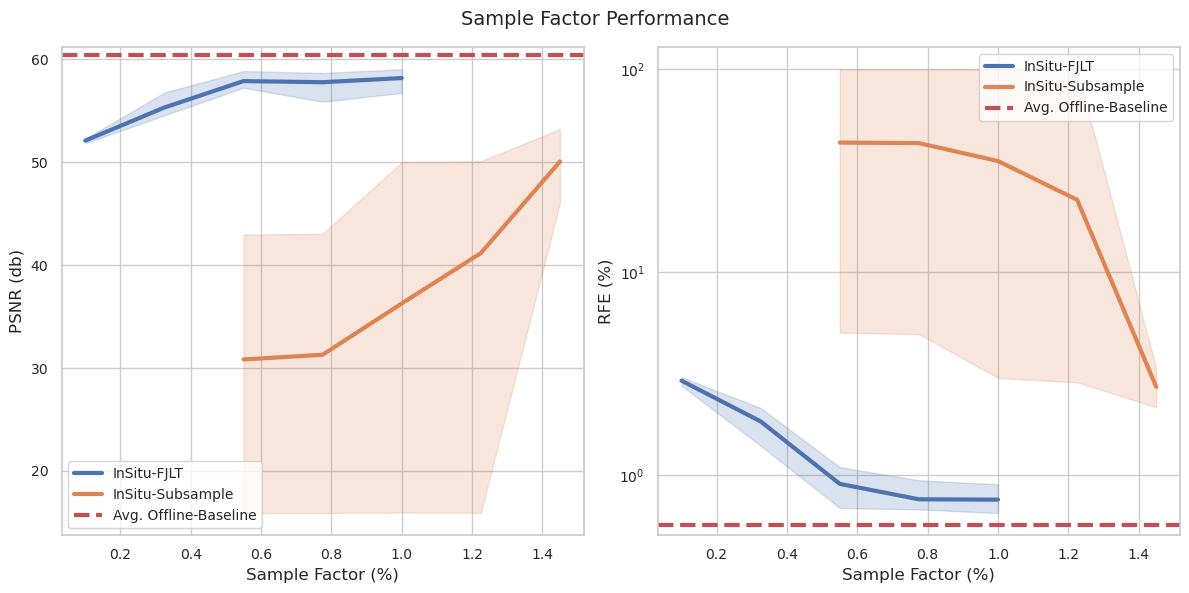

In [14]:
#Plot
fig, ax = plt.subplots(1,2,figsize=(12,6))

#fjlt
sns.lineplot(data=df["fjlt"], x="Sample Factor", y="PSNR", ax=ax[0], errorbar=("pi", 100), label="InSitu-FJLT", lw=lw)
ax[0].set_xlabel("Sample Factor (%)")
ax[0].set_ylabel("PSNR (db)")

sns.lineplot(data=df["fjlt"], x="Sample Factor", y="RFE", ax=ax[1], errorbar=("pi", 100), label="InSitu-FJLT", lw=lw)
ax[1].set_xlabel("Sample Factor (%)")
ax[1].set_ylabel("RFE (%)")

#subsample
sns.lineplot(data=df["subsample"], x="Sample Factor", y="PSNR", ax=ax[0], errorbar=("pi", 100), label="InSitu-Subsample", lw=lw)
ax[0].set_xlabel("Sample Factor (%)")
ax[0].set_ylabel("PSNR (db)")

sns.lineplot(data=df["subsample"], x="Sample Factor", y="RFE", ax=ax[1], errorbar=("pi", 100), label="InSitu-Subsample", lw=lw)
ax[1].set_xlabel("Sample Factor (%)")
ax[1].set_ylabel("RFE (%)")

#
ax[1].set(yscale="log")

#offline
ax[0].axhline(mean_PSNR, c="r", ls="--", label="Avg. Offline-Baseline", lw=lw)
ax[1].axhline(mean_RFE, c="r", ls="--", label="Avg. Offline-Baseline", lw=lw)

ax[0].legend()
ax[1].legend()

fig.suptitle("Sample Factor Performance")

fig.tight_layout()

In [15]:
fig.savefig("misc/figures/sample-factor-performance.pdf", bbox_inches="tight")

# Ignition Plots

In [3]:
#Load Data
frame = 12

raw = np.load("data/ignition/features.npy")[frame,:,1].reshape(50,50)
r_baseline = np.load("lightning_logs/ignition/hnet_offline_full/version_3/reconstruction.npy")[frame,:,1].reshape(50,50)
r_off_sub = np.load("lightning_logs/ignition/hnet_offline_subsample/version_3/reconstruction.npy")[frame,:,1].reshape(50,50)
r_off_fjlt = np.load("lightning_logs/ignition/hnet_offline_fjlt/version_3/reconstruction.npy")[frame,:,1].reshape(50,50)
r_sub = np.load("lightning_logs/ignition/hnet_online_subsample/version_3/reconstruction.npy")[frame,:,1].reshape(50,50)
r_fjlt = np.load("lightning_logs/ignition/hnet_online_fjlt/version_3/reconstruction.npy")[frame,:,1].reshape(50,50)

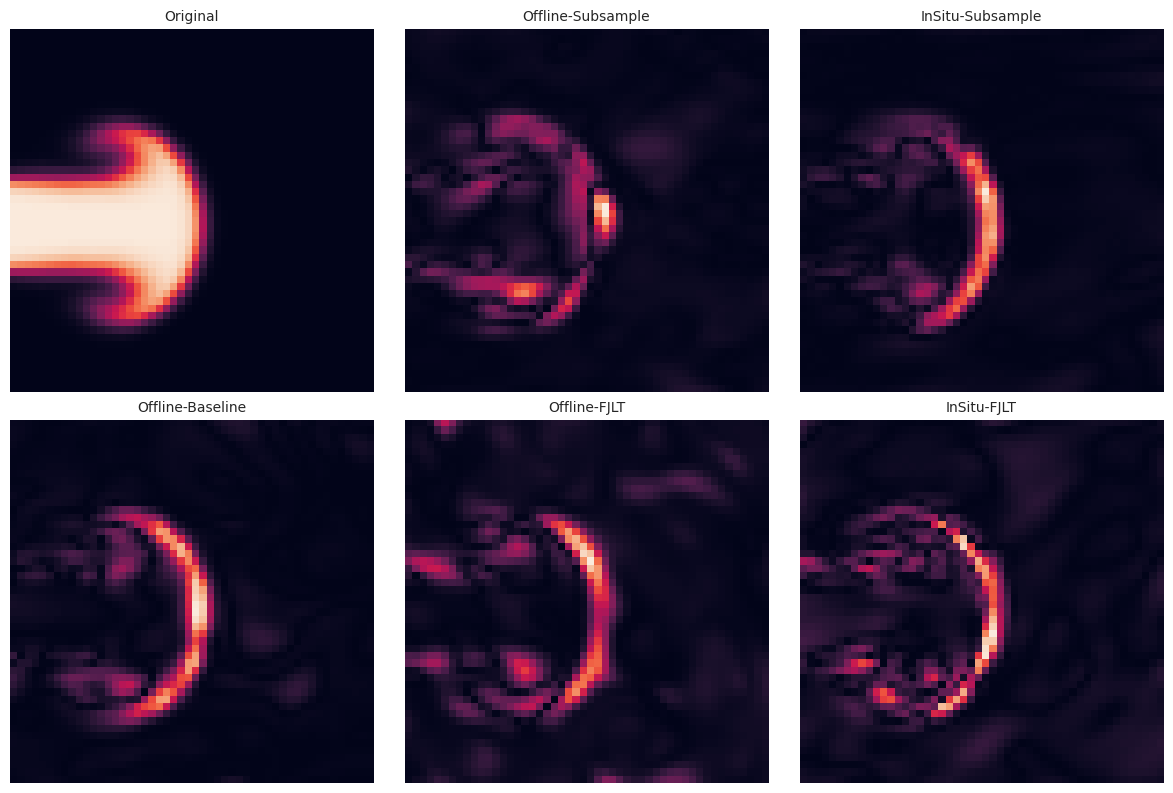

In [18]:
fig, axs = plt.subplots(2,3,figsize=(12,8))

axs[0,0].imshow(raw)
axs[0,0].set_title("Original")

# axs[1,0].imshow(r_baseline)
axs[1,0].imshow(abs(raw-r_baseline))
axs[1,0].set_title("Offline-Baseline")

# axs[0,1].imshow(r_off_sub)
axs[0,1].imshow(abs(raw-r_off_sub))
axs[0,1].set_title("Offline-Subsample")

# axs[1,1].imshow(r_off_fjlt)
axs[1,1].imshow(abs(raw-r_off_fjlt))
axs[1,1].set_title("Offline-FJLT")

# axs[0,2].imshow(r_sub)
axs[0,2].imshow(abs(raw-r_sub))
axs[0,2].set_title("InSitu-Subsample")

# axs[1,2].imshow(r_fjlt)
axs[1,2].imshow(abs(raw-r_fjlt))
axs[1,2].set_title("InSitu-FJLT")

for ax in np.ravel(axs):
    ax.grid(False)
    ax.axis(False)

fig.tight_layout()

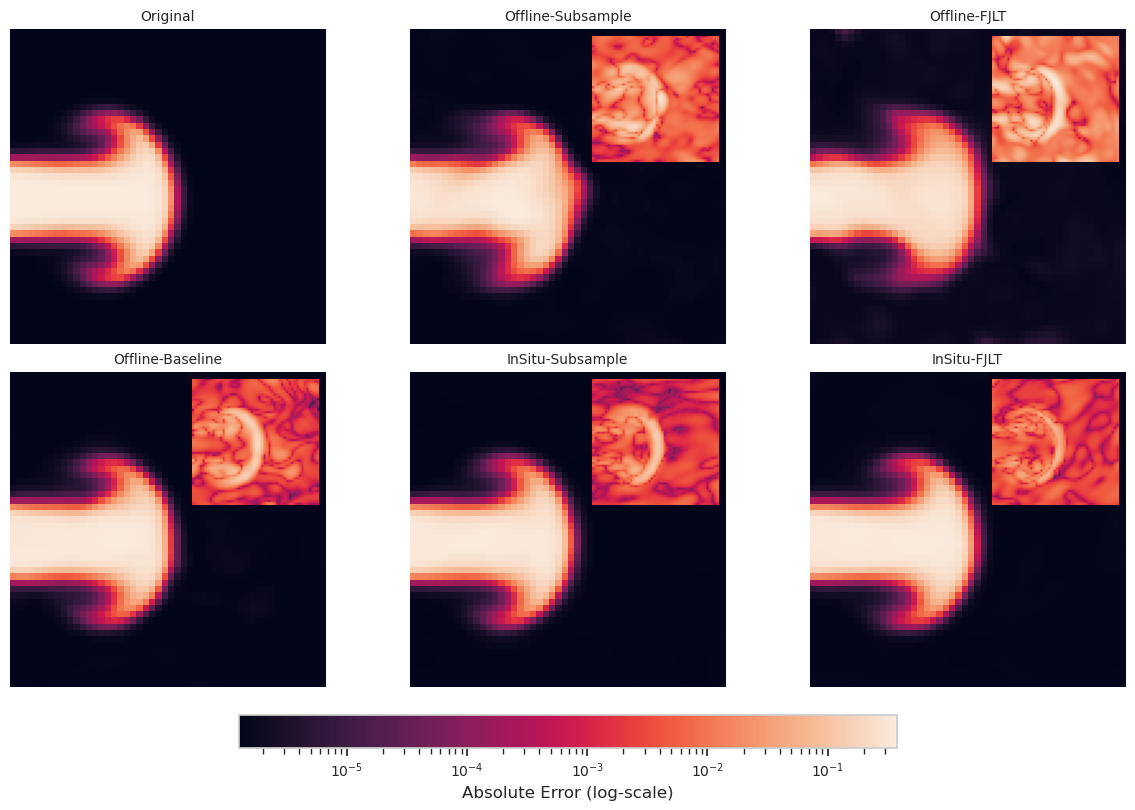

In [7]:
#Plotting code modified from ChatGPT
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Reconstructions and titles
reconstructions = [
    r_off_sub,
    r_off_fjlt,
    r_baseline,
    r_sub,
    r_fjlt
]

titles = [
    "Offline-Subsample",
    "Offline-FJLT",
    "Offline-Baseline",
    "InSitu-Subsample",
    "InSitu-FJLT"
]

# Compute absolute errors
errors = [abs(raw - rec) for rec in reconstructions]

# Safe normalization for log-scale
vmin = min(np.min(err[np.nonzero(err)]) for err in errors)
vmax = max(np.max(err) for err in errors)

# Create 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)
axes = axs.ravel()

for ax in np.ravel(axs):
    ax.grid(False)
    ax.axis(False)

# --- 1️⃣ Plot original image (no inset) ---
axes[0].imshow(raw)
axes[0].set_title("Original")

# --- 2️⃣ Plot reconstructed images + inset errors ---
for ax, rec, err, title in zip(axes[1:], reconstructions, errors, titles):
    # Main reconstructed image
    ax.imshow(rec)
    ax.set_title(f"{title}")

    # Inset showing log-scale error
    inset_ax = inset_axes(ax, width="40%", height="40%", loc='upper right', borderpad=0.5)
    im_inset = inset_ax.imshow(err, norm=LogNorm(vmin=vmin, vmax=vmax))
    inset_ax.grid(False)
    inset_ax.axis(False)

# --- 3️⃣ Shared colorbar for all insets ---
cbar = fig.colorbar(
    im_inset, 
    ax=axes, 
    orientation='horizontal',   # this ensures proper placement below all subplots
    fraction=0.05,       # relative size
    pad=0.04    # spacing between plots and colorbar
)
cbar.set_label("Absolute Error (log-scale)")

In [9]:
fig.savefig("misc/figures/ignition-comparison.pdf")

In [58]:
df = tb.SummaryReader("lightning_logs/ignition/hnet_online_fjlt/version_3/events.out.tfevents.1726546773.bgpu-biokem2.rc.int.colorado.edu.780349.0").scalars
full = df[df['tag']=='train_loss_1']['value'].to_numpy()
sketch = df[df['tag']=='train_loss_2']['value'].to_numpy()

In [59]:
full.shape

(225000,)

In [60]:
#Load Data
df = tb.SummaryReader("lightning_logs/ignition/hnet_online_fjlt/version_3/events.out.tfevents.1726546773.bgpu-biokem2.rc.int.colorado.edu.780349.0").scalars
full = df[df['tag']=='train_loss_1']['value'].to_numpy()
sketch = df[df['tag']=='train_loss_2']['value'].to_numpy()

full = full[499::500]
sketch = sketch[499::500]

#Testing error
raw = np.load("data/ignition/features.npy")[:,:,[1]]
r_fjlt = np.load("lightning_logs/ignition/hnet_online_fjlt/version_3/reconstruction.npy")[:,:,[1]]

n = np.sum((raw-r_fjlt)**2, axis=(1,2))
d = np.sum((raw)**2, axis=(1,2))

test = np.sqrt(n/d)

#Baseline testing error

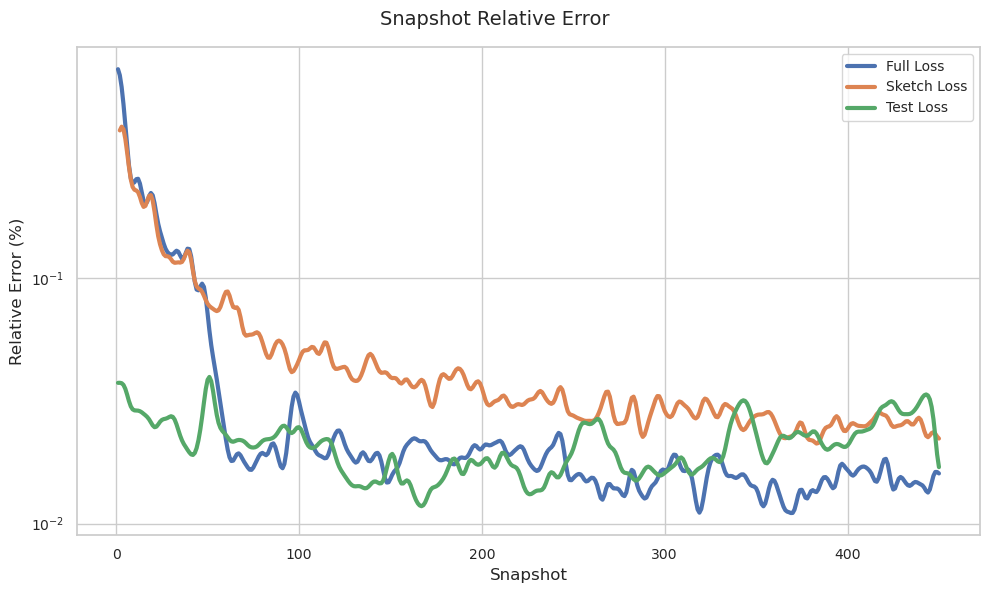

In [61]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

x = np.arange(1,451)

sns.lineplot(x=x, y=scp.ndimage.gaussian_filter(full, 2.0), ax=ax, label="Full Loss", lw=lw)
sns.lineplot(x=x[1:], y=scp.ndimage.gaussian_filter(sketch, 2.0)[1:], ax=ax, label="Sketch Loss", lw=lw)
sns.lineplot(x=x, y=scp.ndimage.gaussian_filter(test, 2.0), ax=ax, label="Test Loss", lw=lw)

ax.set_xlabel("Snapshot")
ax.set_ylabel("Relative Error (%)")

ax.set(yscale="log")
ax.legend()

fig.suptitle("Snapshot Relative Error")

fig.tight_layout()

In [62]:
fig.savefig("misc/figures/ignition-r3error.pdf", bbox_inches="tight")

# Channel Flow

In [4]:
#Load Data
frame = 249
z_slice = 31

raw = np.load("data/channel_flow/features.npy")[frame,:,:].reshape(64,64,64,-1)[:,:,z_slice,:]
r_baseline = np.load("lightning_logs/channel_flow/hnet_offline_full/version_2/reconstruction.npy")[frame,:,:].reshape(64,64,64,-1)[:,:,z_slice,:]
r_subsample = np.load("lightning_logs/channel_flow/hnet_online_subsample/version_4/reconstruction.npy")[frame,:,:].reshape(64,64,64,-1)[:,:,z_slice,:]
r_fjlt = np.load("lightning_logs/channel_flow/hnet_online_fjlt/version_4/reconstruction.npy")[frame,:,:].reshape(64,64,64,-1)[:,:,z_slice,:]

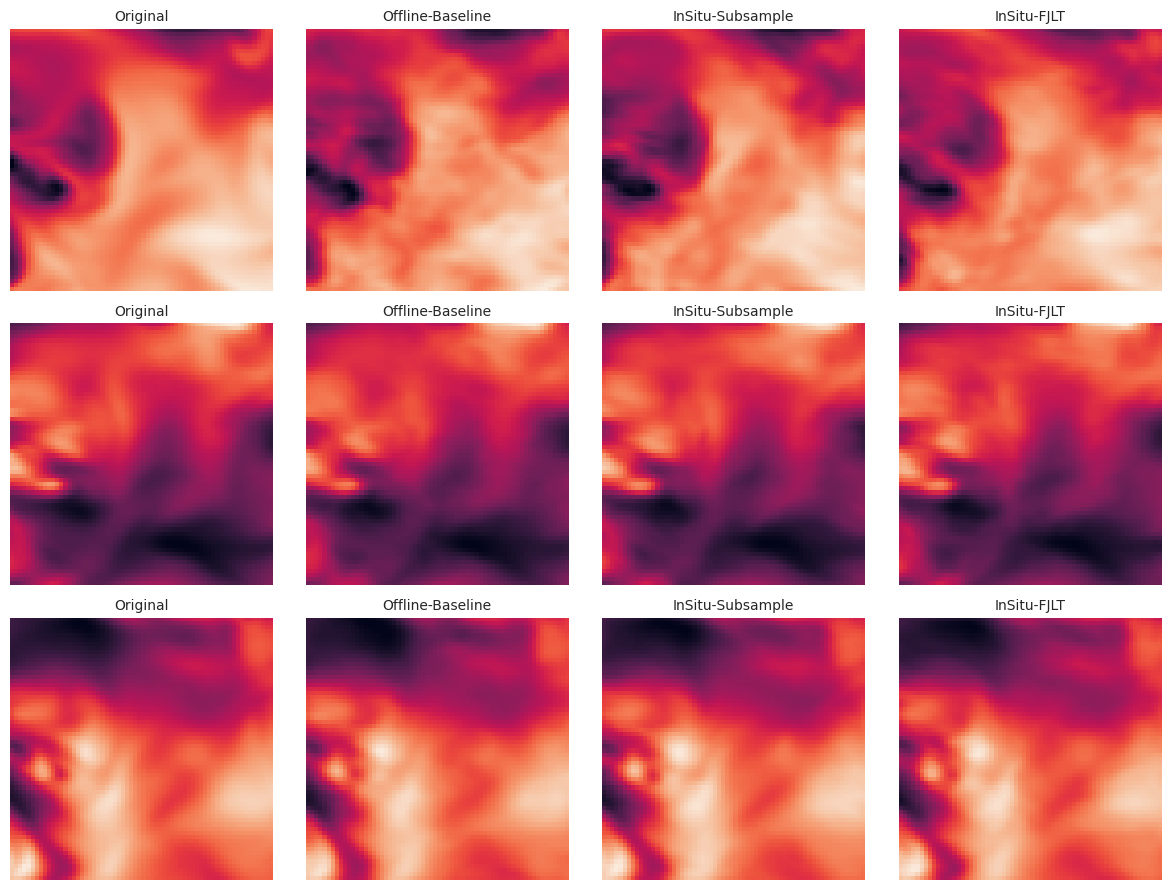

In [65]:
fig, axs = plt.subplots(3,4,figsize=(12,9))

for i in range(3):
    axs[i,0].imshow(raw[:,:,i])
    axs[i,0].set_title("Original")
    
    axs[i,1].imshow(r_baseline[:,:,i])
    axs[i,1].set_title("Offline-Baseline")

    axs[i,2].imshow(r_subsample[:,:,i])
    axs[i,2].set_title("InSitu-Subsample")
    
    axs[i,3].imshow(r_fjlt[:,:,i])
    axs[i,3].set_title("InSitu-FJLT")

for ax in np.ravel(axs):
    ax.grid(False)
    ax.axis(False)

fig.tight_layout()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

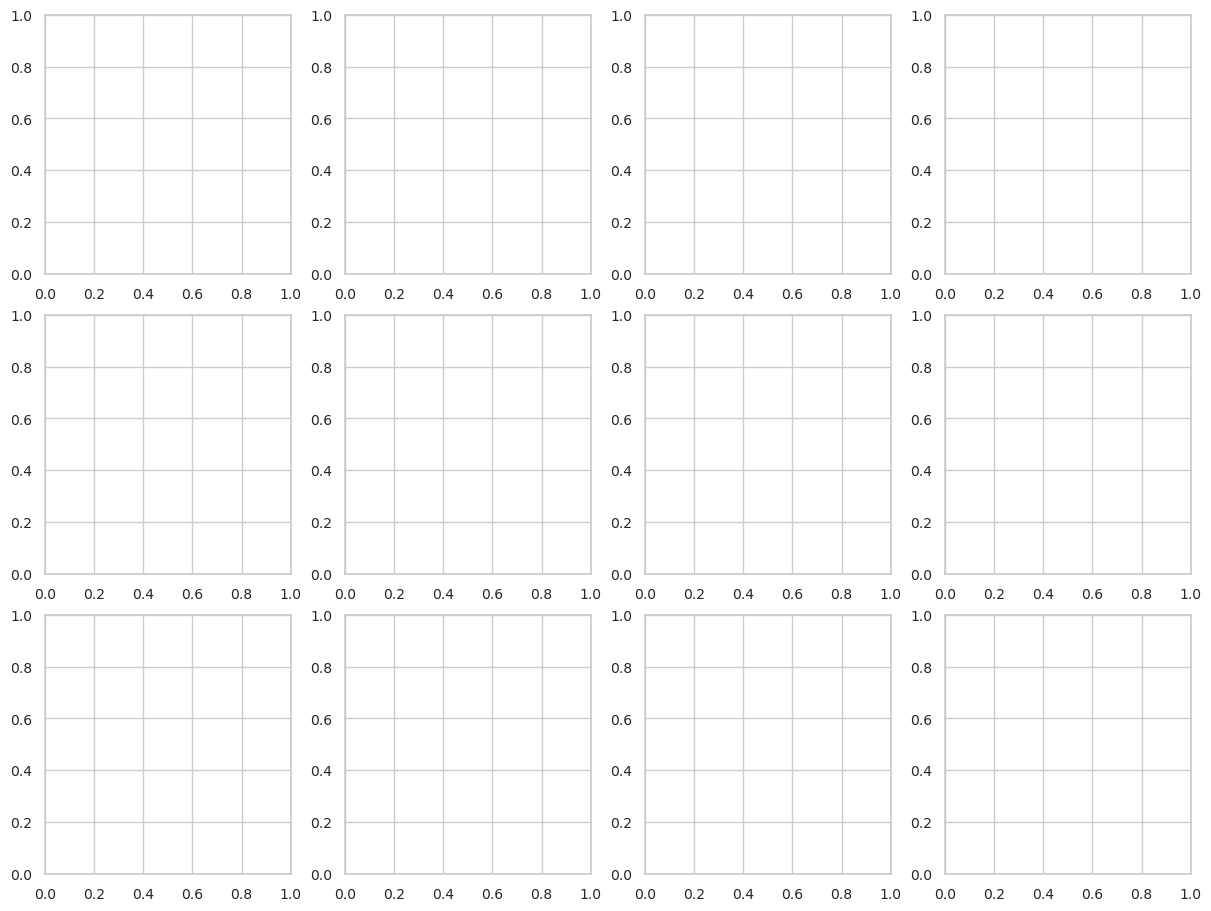

In [31]:
fig, axs = plt.subplots(3, 4, figsize=(12, 9), constrained_layout=True)

dim_names = ["x", "y", "z"]

for i in range(3):
    axs[i, 0].imshow(raw[:, :, i])
    axs[i, 0].set_title("Original")
    
    im1 = axs[i, 1].imshow(r_baseline[:, :, i])
    axs[i, 1].set_title("Offline-Baseline")

    im2 = axs[i, 2].imshow(r_subsample[:, :, i])
    axs[i, 2].set_title("InSitu-Subsample")
    
    im3 = axs[i, 3].imshow(r_fjlt[:, :, i])
    axs[i, 3].set_title("InSitu-FJLT")

    cbar = fig.colorbar(
        im3,
        ax=axs[i, 1:4],
        orientation='vertical',
        fraction=0.05,
        pad=0.04
    )
    cbar.set_label(dim_names[i]+"-Velocity", fontsize=12)

for ax in np.ravel(axs):
    ax.grid(False)
    ax.axis(False)

# fig.tight_layout()

In [13]:
fig.savefig("misc/figures/channel-flow-comparison.pdf", bbox_inches='tight')